# adVAE Tutorial: Generating Synthetic Gene Expression Profiles and MRI Images for Alzheimer's Disease on Example Dataset

---

### Aim:

This tutorial demonstrates how to use `adVAE`, a variational autoencoder pipeline for generating synthetic gene expression data and MRI data. The tool can be applied to RNA microarray data as well as Gain-field corrected, atlas-registered average brain scans images from Alzheimer's Disease (AD) patients.

<br>


### Biological Question:

Can adVAE generate synthetic gene expression profiles and MRI images that retain biological characteristics of Alzheimer's gene expression patterns and MRI anatomical features associated with Alzheimer's Disease? Is this generated synthetic data useful for training classifier models that need to be trained on Alzheimer's-specific data?

<br>

### Example Dataset Used:
For the Gene Expression pipeline, I use a subset of a real RNA microarray dataset from the AMP-AD MSBB cohort, accessed via the AD Knowledge Portal.
- **Format**: RNA microarray expression values (.tsv)
- **Samples**: 5 brain samples from AD patients
- **Genes**: ~40,000 probes per sample
- **Preprocessing**: Scaled, PCA-reduced to preserve 95% variance
- **Source**: [AD Knowledge Portal](https://adknowledgeportal.synapse.org/)

For the MRI pipeline, I use a subset of real MRI data from the OASIS-1 dataset, containing structural brain scans from cognitively abnormal and Alzheimer's-affected individuals.

- **Format**: Gain-field corrected, atlas-registered average brain scans images (.img) > tensor 
- **Samples**: 9 subjects, 20 slices each
- **Preprocessing**:
  - Gain-field corrected, atlas-registered average MRI volumes
  - Transverse slices extracted
  - Resized to 128x128 resolution
  - Converted to grayscale tensors
- **Source:** [OASIS](https://sites.wustl.edu/oasisbrains/home/oasis-1/)

<br> 

### Note:
This example tutorial uses a small sample dataset for demonstration purposes only. The results are NOT representative of full model performance — more data is needed for training. This is intended to showcase the functioning of the adVAE pipelines for gene expression and MRI data.

<br>

---

### Initialisation

In [1]:
import sys
import os
import torch
sys.path.append(os.path.abspath(".."))

In [13]:
from adVAE.config import gene_expression, mri
from adVAE.training.train_gene_expression import train_model as train_gene
from adVAE.training.train_mri import train_model as train_mri
from adVAE.training.evaluate_gene_expression import evaluate_model as evaluate_gene
from adVAE.training.evaluate_mri import evaluate_model as evaluate_mri
from adVAE.visualization.visualize_gene_expression import visualize_latent_space as visualize_gene
from adVAE.visualization.visualize_mri import visualize_latent_space as visualize_mri
from adVAE.training.generate_synthetic_gene_expression import generate_and_save as generate_gene
from adVAE.training.generate_synthetic_mri import generate_and_save as generate_mri
from adVAE.data_preprocessing.gene_expression.preprocess import preprocess_pipeline as preprocess_gene
from adVAE.data_preprocessing.mri.preprocess import preprocess_pipeline as preprocess_mri
from adVAE.training.evaluate_synthetic_gene_expression import evaluate_synthetic_data as evaluate_synthetic_gene_data
from adVAE.training.evaluate_synthetic_mri import evaluate_synthetic_data as evaluate_synthetic_mri_data
from adVAE.utils.generator import generate_synthetic_data_from_posteriors
from adVAE.models.mri_vae import MRIVAE
from torch.utils.data import DataLoader
from adVAE.data_preprocessing.mri.dataset import MRIDataset


In [3]:
from datetime import datetime
timestamp = datetime.now().strftime("%Y-%m-%d")

### Implementing the gene expression-based pipeline

In [4]:
print("Gene Expression Configuration:", gene_expression)
cfg = gene_expression
cfg = gene_expression.copy()
cfg["data_folder"] = "../data/example_gene_expression"
cfg["data_path"] = "../data/example_gene_expression/processed/example_gene_expression.pt"
cfg["weights_path"] = "../results/example_gene_expression/model/vae_weights_example.pth"
cfg["output_dir"] = "../results/example_gene_expression"
cfg["pca_model_path"] = "../data/example_gene_expression/processed/pca_model_example.pkl"
cfg["scaler_path"] = "../data/example_gene_expression/processed/scaler_example.pkl"
cfg["epochs"] = 5
cfg["num_samples"] = 100

Gene Expression Configuration: {'hidden_dim': 32, 'latent_dim': 8, 'batch_size': 4, 'epochs': 100, 'lr': 0.001, 'num_samples': 5000, 'data_folder': 'data/AMP_AD_MSBB_MSSM', 'n_components': 0.95, 'scale_method': 'standard', 'visualize': False, 'aggregate_by_gene': True, 'data_path': 'data/processed/X_pca_2025-04-22.npy', 'weights_path': 'results/gene_expression/model/vae_weights_2025-04-22.pth', 'output_dir': 'results/gene_expression', 'beta': 0.1, 'pca_model_path': 'data/processed/pca_model_2025-04-22.pkl', 'scaler_path': 'data/processed/scaler_2025-04-22.pkl'}


**Data Preprocessing:**

In [5]:
# Directory creation
os.makedirs("../data/example_gene_expression/processed", exist_ok=True)
os.makedirs("../results/example_gene_expression/model", exist_ok=True)

In [6]:
print("Preprocessing gene expression data...")
df, X_pca, scaler, pca_model = preprocess_gene(
    n_components=cfg["n_components"],
    data_folder=cfg["data_folder"],
    scale_method=cfg["scale_method"],
    aggregate_by_gene=cfg["aggregate_by_gene"],
    save_dir="../data/example_gene_expression/processed"
)

# Saving the data
torch.save(torch.tensor(X_pca, dtype=torch.float32), cfg["data_path"])
import pickle
with open(cfg["pca_model_path"], "wb") as f:
    pickle.dump(pca_model, f)
with open(cfg["scaler_path"], "wb") as f:
    pickle.dump(scaler, f)
print("Finished preprocessing and saving processed data.")

Preprocessing gene expression data...
Missing values filled: 0
Aggregated probe-level data to 21025 unique genes.
Saved raw CSV to ../data/example_gene_expression/processed/raw_gene_expression_2025-04-22.csv
Saved PCA-reduced data and models to ../data/example_gene_expression/processed
Finished preprocessing and saving processed data.


**Model Training:**

Epoch 1/5 - Loss: 1.3936 - Accuracy: 0.2651
Epoch 2/5 - Loss: 0.6920 - Accuracy: 0.3327
Epoch 3/5 - Loss: 0.6277 - Accuracy: 0.3520
Epoch 4/5 - Loss: 0.6053 - Accuracy: 0.3529
Epoch 5/5 - Loss: 0.5961 - Accuracy: 0.3579
Model weights saved to ../results/example_gene_expression/model/vae_weights_example.pth
Loss curve saved to ../results/example_gene_expression/loss_curve_2025-04-22.png
Accuracy curve saved to ../results/example_gene_expression/accuracy_curve_2025-04-22.png


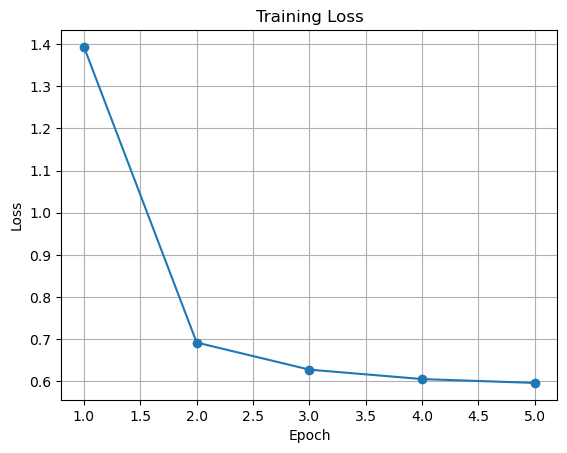

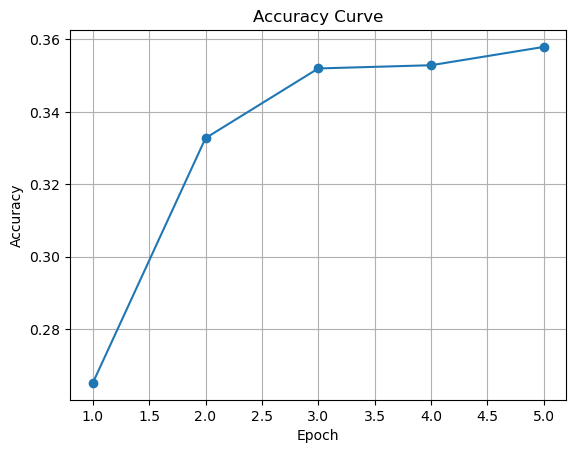

In [7]:
gene_model = train_gene(cfg)

**Model Evaluation:**

Evaluating performance of GeneExpressionVAE...
Reconstruction Accuracy (original space): 0.3925
Mean Absolute Error (original space): 3.6198
Mean Squared Error (original space): 41.0979
KS Test p-value: 9.224e-13 | Statistic: 0.0102
T-Test p-value: 0.07563 | Statistic: -1.7766
Mean Pearson Correlation across features: 0.9934
Reconstruction distribution plot saved to ../results/example_gene_expression/reconstruction_distribution_2025-04-22.png
Finished evaluating performance


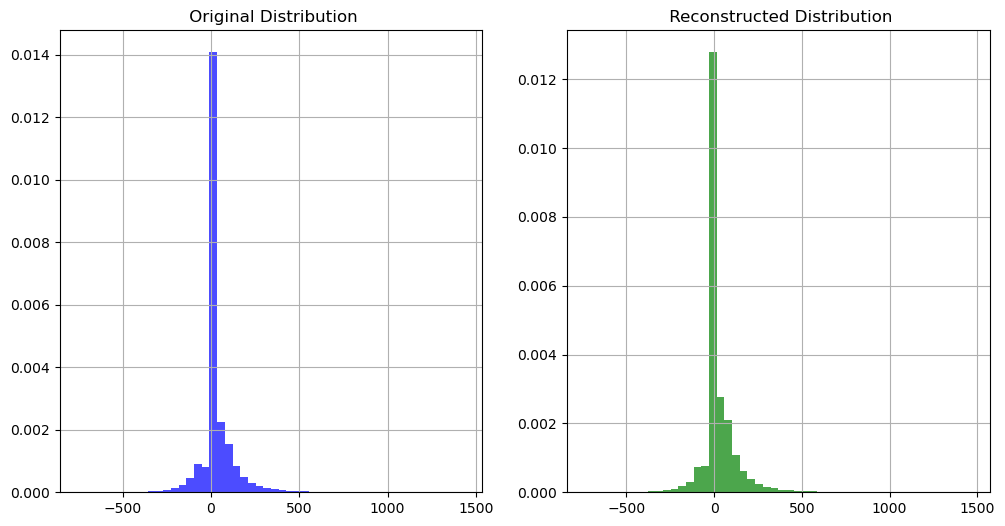

In [8]:
print("Evaluating performance of GeneExpressionVAE...")
evaluate_gene(cfg)
print(f"Finished evaluating performance")

**Model Visualisation:**

Visualizing latent space of GeneExpressionVAE...
Latent space plot saved to ../results/example_gene_expression/latent_pca_2025-04-22.png
Finished visualizing the latent space


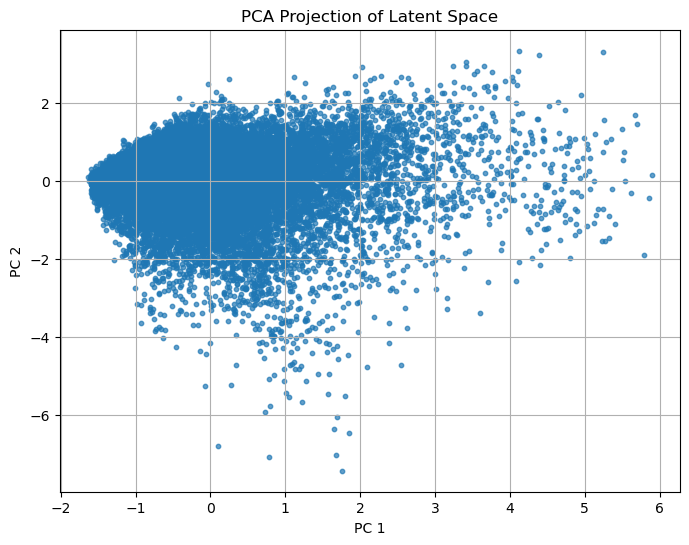

In [9]:
print("Visualizing latent space of GeneExpressionVAE...")
visualize_gene(cfg)
print(f"Finished visualizing the latent space")

**Synthetic Gene Expression Data Generation:**

In [10]:
print("Generating synthetic gene expression data...")
generate_gene(cfg)
print(f"Finished generating synthetic data")

Generating synthetic gene expression data...
Generated 100 synthetic samples saved to ../results/example_gene_expression/synthetic_gene_expression_2025-04-22.tsv
Finished generating synthetic data


**Synthetic Data Validation:**

Validating synthetic gene expression data...
Real data shape: (21025, 13) | Synthetic data shape: (100, 13)
Mean Absolute Error: 1.3348
Mean Squared Error: 3.9696
Mean Pearson Correlation (mean vectors): 1.0000
KS Test: p = 0.5249, stat = 0.0224
T-Test: p = 0.7812, stat = 0.2778
Reconstruction distribution plot saved to ../results/example_gene_expression/synthetic_vs_real_distribution_2025-04-22.png


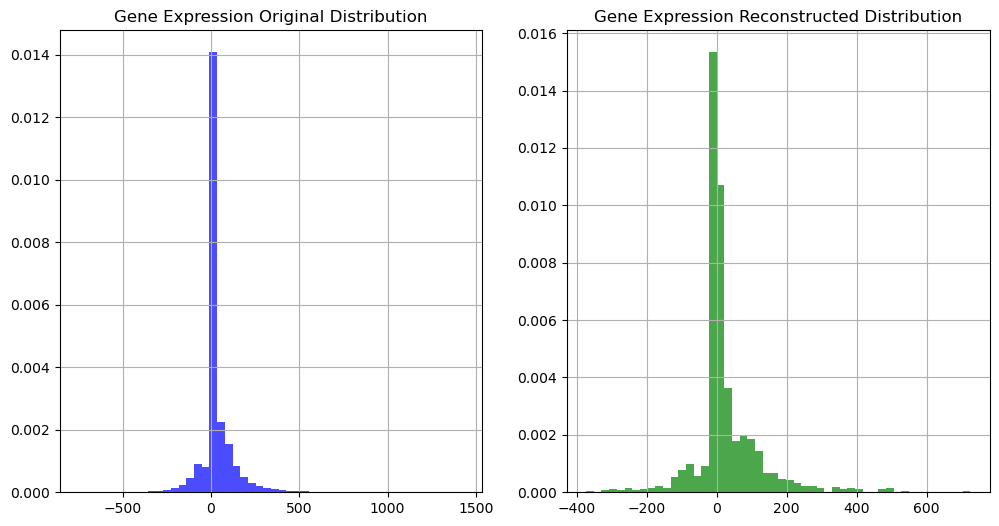

In [11]:
print("Validating synthetic gene expression data...")
synthetic_path = f"../results/example_gene_expression/synthetic_gene_expression_{timestamp}.tsv"
evaluate_synthetic_gene_data(cfg, synthetic_path)

### Implementing the MRI-based pipeline

In [4]:
print("MRI Configuration:", mri)
cfg = mri
cfg["data_folder"] = "../data/OASIS_1"
cfg["data_path"] = "../data/example_mri/processed/example_mri.pt"
cfg["weights_path"] = f"../results/example_mri/vae_weights_lat64_b0.1_lr0.001_{timestamp}.pth"
cfg["output_dir"] = "../results/example_mri"
cfg["epochs"] = 5
cfg["num_samples"] = 10

MRI Configuration: {'latent_dim': 64, 'batch_size': 32, 'epochs': 10, 'lr': 0.001, 'data_folder': 'data/OASIS_1', 'data_path': 'data/processed/mri_2025-04-22.pt', 'weights_path': 'results/mri/model/vae_weights_lat64_b0.1_lr0.001_2025-04-22.pth', 'output_dir': 'results/mri', 'beta': 0.1, 'num_samples': 50}


**Data Preprocessing:**

In [5]:
print("Preprocessing MRI data...")
preprocess_mri(load_example_data=True)

Preprocessing MRI data...
OAS1_0003_MR1: extracted 20 slices
OAS1_0021_MR1: extracted 20 slices
OAS1_0022_MR1: extracted 20 slices
OAS1_0023_MR1: extracted 20 slices
OAS1_0028_MR1: extracted 20 slices
OAS1_0031_MR1: extracted 20 slices
OAS1_0035_MR1: extracted 20 slices
OAS1_0041_MR1: extracted 20 slices
OAS1_0042_MR1: extracted 20 slices

Saved 180 slices to ../data/example_mri/processed/example_mri.pt


**Model Training:**

Training MRIVAE on MRI data...
Epoch 1/5 | Loss: 99725653.4606 | Accuracy: 0.2201
Epoch 2/5 | Loss: 14785.2089 | Accuracy: 0.2602
Epoch 3/5 | Loss: 3517.2825 | Accuracy: 0.3480
Epoch 4/5 | Loss: 2082.9149 | Accuracy: 0.4312
Epoch 5/5 | Loss: 1604.4918 | Accuracy: 0.4528
Model weights saved to ../results/example_mri/vae_weights_lat64_b0.1_lr0.001_2025-04-22.pth
Loss curve saved to ../results/example_mri/loss_curve_2025-04-22.png
Accuracy curve saved to ../results/example_mri/accuracy_curve_2025-04-22.png
Saved processed data to ../results/example_mri


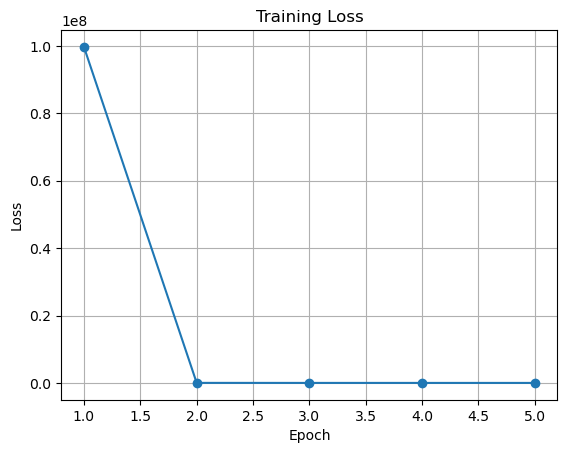

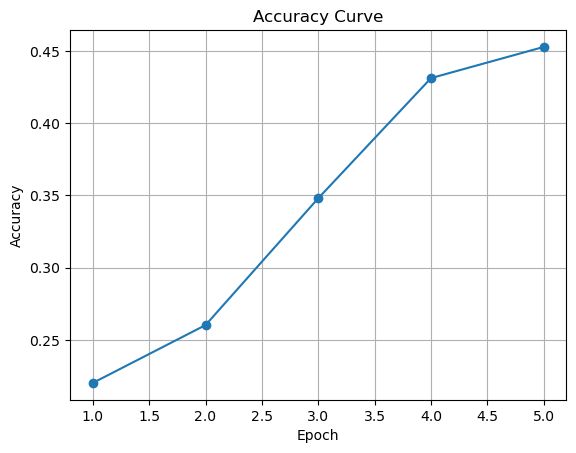

In [5]:
print("Training MRIVAE on MRI data...")
train_mri(data_path=cfg["data_path"], latent_dim=cfg["latent_dim"], batch_size=cfg["batch_size"],
          epochs=cfg["epochs"], lr=cfg["lr"], output_dir=cfg["output_dir"])
print(f"Saved processed data to {cfg['output_dir']}")

**Model Evaluation:**

Evaluating performance of MRIVAE...
Reconstruction Accuracy: 0.3170
Mean SSIM: 0.1282
Mean PSNR: 5.8294
Mean MSE: 0.2683
Mean RMSE: 0.5146
Mean MAE: 0.3885
t-test: stat = 1752.9174, p = 0.0000e+00
KS-test: stat = 0.7452, p = 0.0000e+00
Reconstruction distribution plot saved to results/mri/reconstruction_distribution_2025-04-22.png
Finished evaluating performance


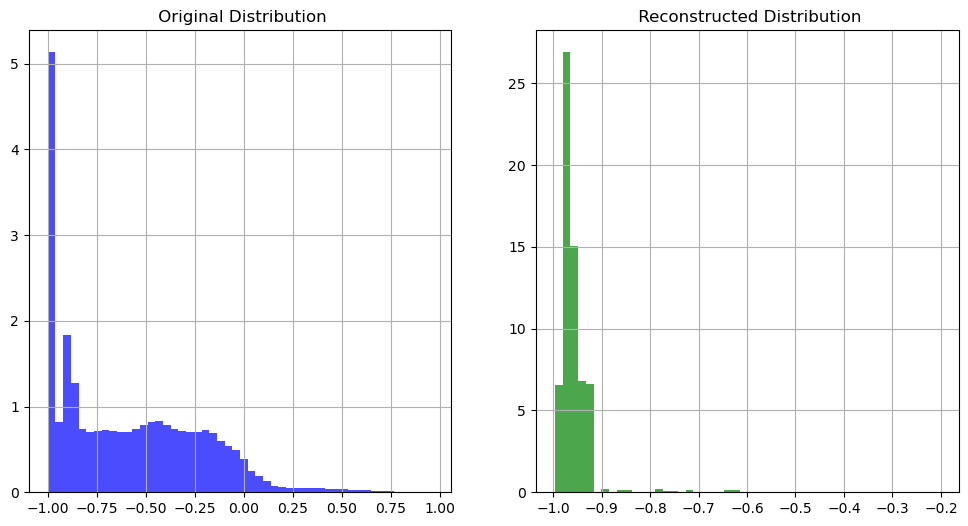

In [5]:
print("Evaluating performance of MRIVAE...")
evaluate_mri(weights_path=cfg["weights_path"], data_path=cfg["data_path"])
print(f"Finished evaluating performance")

**Model Visualisation:**

Visualizing latent space of MRIVAE...
Latent space plot saved to results/mri/latent_pca.png
Finished visualizing the latent space


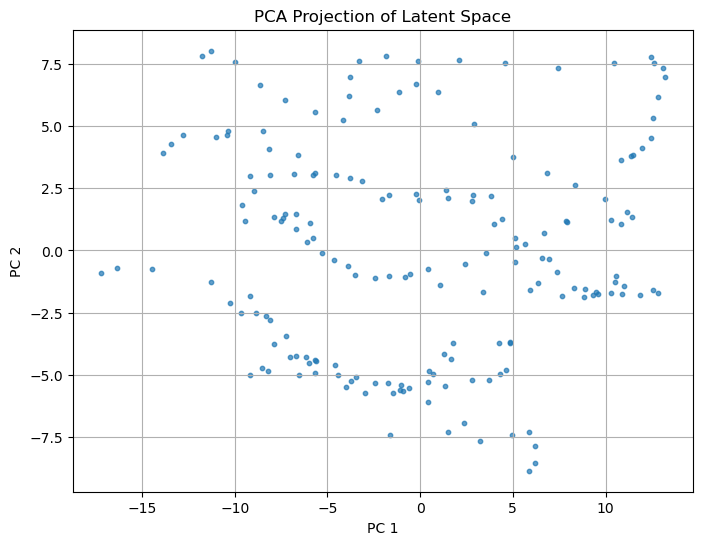

In [7]:
print("Visualizing latent space of MRIVAE...")
visualize_mri(weights_path=cfg["weights_path"], data_path=cfg["data_path"], latent_dim=cfg["latent_dim"])
print(f"Finished visualizing the latent space")

**Synthetic MRI Data Generation:**

In [10]:
print("Generating synthetic MRI data...")
generate_mri(weights_path=cfg["weights_path"], latent_dim=cfg["latent_dim"], num_samples=50,
             output_dir=os.path.join(cfg["output_dir"], "synthetic_gifs"), data_path=cfg["data_path"])
print(f"Finished generating synthetic data")

Generating synthetic MRI data...
Saved 50 synthetic MRI GIFs to ../results/example_mri/synthetic_gifs
Finished generating synthetic data


**Synthetic Data Validation:**

Validating synthetic MRI data...
Real data shape: (180, 128, 128) | Synthetic data shape: (10, 128, 128)
Mean Absolute Error: 0.3864
Mean Squared Error: 0.2218
Root Mean Squared Error: 0.4710
Mean PSNR: 5.9743
Mean SSIM: 0.1304
KS Test: p = 0, stat = 0.7452
T-Test: p = 0, stat = 414.9086
Reconstruction distribution plot saved to ../results/example_mri/synthetic_vs_real_distribution_2025-04-22.png


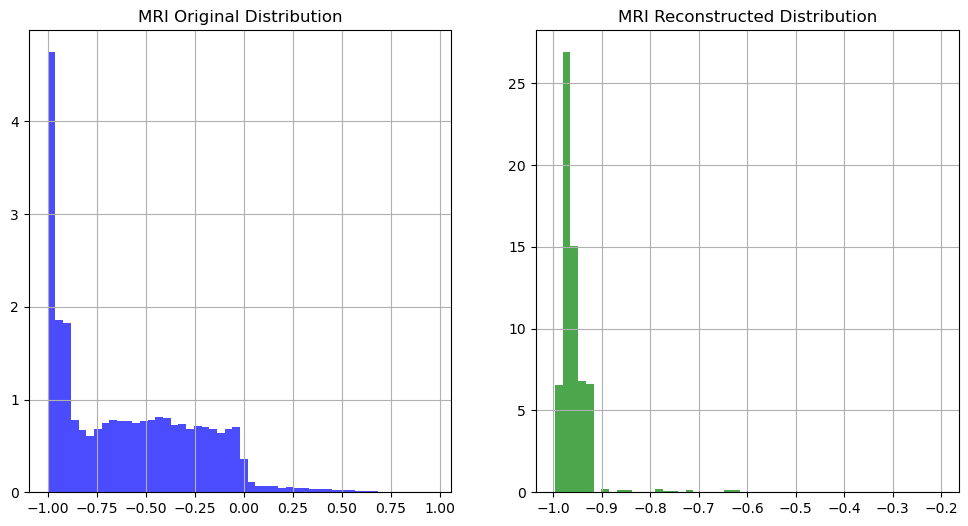

In [14]:
print("Validating synthetic MRI data...")
model = MRIVAE(latent_dim=cfg["latent_dim"]) # Load model
model.load_state_dict(torch.load(cfg["weights_path"], map_location="cpu"))
model.eval()

dataset = MRIDataset(cfg["data_path"]) # Load real data
loader = DataLoader(dataset, batch_size=cfg.get("batch_size", 32), shuffle=True)

synthetic_np = generate_synthetic_data_from_posteriors( # Generate synthetic data using learned posterior
    model,
    dataloader=loader,
    num_samples=cfg["num_samples"],
    device="cpu"
)

synthetic_tensor = torch.tensor(synthetic_np, dtype=torch.float32) # Convert and evaluate
evaluate_synthetic_mri_data(cfg, synthetic_tensor)